# English to Bahasa Indonesian Seq-2-Seq Translation

In [1]:
# IPython candies...
from IPython.display import Image
from IPython.core.display import HTML 
# Imports we need.
import random

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F

use_cuda = torch.cuda.is_available()

## Data Munging

In [2]:
import pandas as pd
from gensim.corpora.dictionary import Dictionary
from nltk import word_tokenize

fp = open('./corpus/bbc-468.en', 'r')
eng_text = fp.read()
eng_text = eng_text.splitlines()
fp.close()

fp2 = open('./corpus/bbc-468.id', 'r')
id_text = fp2.read()
id_text = id_text.splitlines()
fp2.close()

In [3]:
df_eng_text = pd.DataFrame(eng_text)
df_eng_text = df_eng_text.rename(columns={0:'English'})

df_id_text = pd.DataFrame(id_text)
df_id_text = df_id_text.rename(columns={0:'Indonesian'})


In [4]:
df_eng_text['English'] = df_eng_text['English'].apply(lambda x : x.lstrip())
df_id_text['Indonesian'] = df_id_text['Indonesian'].apply(lambda x : x.lstrip())

In [5]:
df = pd.concat([df_eng_text, df_id_text], axis=1)
df.head()

,English,Indonesian
0,French Muslims fined for face veils,Muslimah Prancis didenda karena mengenakan burka
1,Two French Muslim women have become the first ...,Dua Muslimah Prancis menjadi orang-orang perta...
2,Hind Ahmas and Najaite Ali were each ordered t...,Hind Ahmas dan Najaite Ali diperintahkan memba...
3,Both say they'll appeal as far as the European...,Keduanya menyatakan akan mengajukan banding hi...
4,Some Muslim groups say veiled women have been ...,Sejumlah organisasi Muslim mengatakan wanita-w...


In [6]:
# Use a unique string to indicate START and END of a sentence.
# Assign a unique index to them.
START, START_IDX = '<s>',  0
END, END_IDX = '</s>', 1

# We use this idiom to tokenize our sentences in the dataframe column:
# >>> DataFrame['column'].apply(str.lower).apply(word_tokenize)

# Also we added the START and the END symbol to the sentences. 
english_sents = [START] + df_eng_text['English'].apply(str.lower).apply(word_tokenize) + [END]
indo_sents = [START] + df_id_text['Indonesian'].apply(str.lower).apply(word_tokenize) + [END]

# We're sort of getting into the data into the shape we want. 
# But now it's still too humanly readable and redundant.
## Cut-away: Computers like it to be simpler, more concise. -_-|||
print('First Singlish sentence:', english_sents[0])
print('First English sentence:', indo_sents[0])

First Singlish sentence: ['<s>', 'french', 'muslims', 'fined', 'for', 'face', 'veils', '</s>']
First English sentence: ['<s>', 'muslimah', 'prancis', 'didenda', 'karena', 'mengenakan', 'burka', '</s>']


In [7]:
english_vocab = Dictionary([['<s>'], ['</s>']])
english_vocab.add_documents(english_sents)

indo_vocab = Dictionary([['<s>'], ['</s>']])
indo_vocab.add_documents(indo_sents)

# First ten words in the vocabulary.
print('First 10 Indonesian words in Dictionary:\n', sorted(indo_vocab.items())[:10])
print()
print('First 10 English words in Dictionary:\n', sorted(english_vocab.items())[:10])

First 10 Indonesian words in Dictionary:
 [(0, '<s>'), (1, '</s>'), (2, 'burka'), (3, 'didenda'), (4, 'karena'), (5, 'mengenakan'), (6, 'muslimah'), (7, 'prancis'), (8, ','), (9, '.')]

First 10 English words in Dictionary:
 [(0, '<s>'), (1, '</s>'), (2, 'face'), (3, 'fined'), (4, 'for'), (5, 'french'), (6, 'muslims'), (7, 'veils'), (8, ','), (9, '.')]


In [39]:
import pickle
# Lets save our dictionaries.
with open('./vocabs/indo_vocab.Dictionary.pkl', 'wb') as fout:
    pickle.dump(indo_vocab, fout)
    
with open('./vocabs/english_vocab.Dictionary.pkl', 'wb') as fout:
    pickle.dump(english_vocab, fout)

In [9]:
# Vectorizes a sentence with a given vocab
def vectorize_sent(sent, vocab):
    return vocab.doc2idx([START] + word_tokenize(sent.lower()) + [END])

# Creates a PyTorch variable from a sentence against a given vocab
def variable_from_sent(sent, vocab):
    vsent = vectorize_sent(sent, vocab)
    #print(vsent)
    result = Variable(torch.LongTensor(vsent).view(-1, 1))
    #print(result)
    return result.cuda() if use_cuda else result

# Test
new_kopi = "French Muslims fined for face veils"
variable_from_sent(new_kopi, english_vocab)

tensor([[0],
        [5],
        [6],
        [3],
        [4],
        [2],
        [7],
        [1]], device='cuda:0')

In [10]:
# Prepare the whole training corpus.
indo_tensors = df['Indonesian'].apply(lambda s: variable_from_sent(s, indo_vocab))
print(df.iloc[0]['Indonesian'])
print(indo_tensors[0])
english_tensors = df['English'].apply(lambda s: variable_from_sent(s, english_vocab))
print(df.iloc[0]['English'])
print(english_tensors[0])
# Now, each item in `sent_pairs` is our data point. 
sent_pairs = list(zip(english_tensors, indo_tensors))

Muslimah Prancis didenda karena mengenakan burka
tensor([[0],
        [6],
        [7],
        [3],
        [4],
        [5],
        [2],
        [1]], device='cuda:0')
French Muslims fined for face veils
tensor([[0],
        [5],
        [6],
        [3],
        [4],
        [2],
        [7],
        [1]], device='cuda:0')


# Seq2Seq Model

## Encoder Definition

In [11]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        # Set the no. of nodes for the hidden layer.
        self.hidden_size = hidden_size
        # Initialize the embedding layer with the 
        # - size of input (i.e. no. of words in input vocab)
        # - no. of hidden nodes in the embedding layer
        self.embedding = nn.Embedding(input_size, hidden_size)
        # Initialize the GRU with the 
        # - size of the hidden layer from the previous state
        # - size of the hidden layer from the current state
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        # Feed the input into the embedding layer.
        embedded = self.embedding(input).view(1, 1, -1) # Question: why (1, 1, -1)
        # Feed the embedded layer with the hidden layer to the GRU.
        # Update the output and hidden layer.
        output, hidden = self.gru(embedded, hidden)
        return output, hidden

    def initialize_hidden_states(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        return result.cuda() if use_cuda else result


# Decoder Definition

In [12]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        # Set the no. of nodes for the hidden layer.
        self.hidden_size = hidden_size
        # Initialize the embedding layer with the 
        # - size of output (i.e. no. of words in output vocab)
        # - no. of hidden nodes in the embedding layer
        self.embedding = nn.Embedding(output_size, hidden_size)
        # Initialize the GRU with the 
        # - size of the hidden layer from the previous state
        # - size of the hidden layer from the current state
        self.gru = nn.GRU(hidden_size, hidden_size)
        # Set the output layer to output a specific symbol 
        # from the output vocabulary
        self.softmax = nn.LogSoftmax(dim=1)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        # Feed the input into the embedding layer.
        output = self.embedding(input).view(1, 1, -1)
        # Transform the embedded output with a relu function. 
        output = F.relu(output)
        # Feed the embedded layer with the hidden layer to the GRU.
        # Update the output and hidden layer.
        output, hidden = self.gru(output, hidden)
        # Take the updated output and find the most appropriate
        # output symbol. 
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initialize_hidden_states(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        return result.cuda() if use_cuda else result
        

In [13]:
hidden_size = 10
learning_rate=0.01
batch_size = 2
epochs = 30 # Since we are taking batch_size=2 and epochs=30, we only look at 60 data points.
criterion = nn.NLLLoss()
MAX_LENGTH=80

# Initialize the network for encoder and decoder.
input_vocab, output_vocab = english_vocab, indo_vocab
encoder = EncoderRNN(len(input_vocab), hidden_size)
decoder = DecoderRNN(hidden_size, len(output_vocab))
if use_cuda:
    encoder = encoder.cuda()
    decoder = decoder.cuda()

# Initialize the optimizer for encoder and decoder.
encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)

# If batchsize == 1, choose 1 data points per batch:
##training_data = [[random.choice(sent_pairs)] for i in range(epochs)]

# If batch_size > 1, use random.sample() instead of random.choice:
training_data = [random.sample(sent_pairs, batch_size) for i in range(epochs)]

## Checking the encoder

In [14]:
#############################################
# 2.3.2. Loop through the batches.
#############################################
# Start the training.
for data_batch in training_data:
    # (Re-)Initialize the optimizers, clear all gradients after every batch.
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    # Reset the loss for every batch.
    loss = 0
    for input_variable, target_variable in data_batch:
        # Initialize the hidden_states for the encoder.
        encoder_hidden = encoder.initialize_hidden_states()
        # Initialize the length of the PyTorch variables.
        input_length = input_variable.size()[0]
        target_length = target_variable.size()[0]
        encoder_outputs = Variable(torch.zeros(MAX_LENGTH, encoder.hidden_size))
        encoder_outputs = encoder_outputs.cuda() if use_cuda else encoder_outputs

In [15]:
print("Input variable first: {0}".format(data_batch[0][0]))
print("Target variable first: {0}".format(data_batch[0][1]))
print(input_length)

Input variable first: tensor([[   0],
        [ 221],
        [2085],
        [2095],
        [  55],
        [ 154],
        [2096],
        [  25],
        [2081],
        [  23],
        [ 281],
        [2094],
        [   8],
        [ 398],
        [  25],
        [2081],
        [  23],
        [  25],
        [ 393],
        [   9],
        [   1]], device='cuda:0')
Target variable first: tensor([[   0],
        [ 211],
        [ 151],
        [1095],
        [1924],
        [  53],
        [  67],
        [1143],
        [1643],
        [ 102],
        [ 859],
        [1938],
        [   8],
        [ 433],
        [1928],
        [ 376],
        [   9],
        [   1]], device='cuda:0')
7


In [16]:
#############################################
# 2.3.2. Loop through the batches.
#############################################
# Start the training.
for data_batch in training_data:
    # (Re-)Initialize the optimizers, clear all gradients after every batch.
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    # Reset the loss for every batch.
    loss = 0
    for input_variable, target_variable in data_batch:
        # Initialize the hidden_states for the encoder.
        encoder_hidden = encoder.initialize_hidden_states()
        # Initialize the length of the PyTorch variables.
        input_length = input_variable.size()[0]
        target_length = target_variable.size()[0]
        encoder_outputs = Variable(torch.zeros(MAX_LENGTH, encoder.hidden_size))
        encoder_outputs = encoder_outputs.cuda() if use_cuda else encoder_outputs
        #############################################
        # 2.3.3.  Iterating through each word in the encoder.
        #############################################
        # Iterating through each word in the input.
        for ei in range(input_length):
            # We move forward through each state.
            encoder_output, encoder_hidden = encoder(input_variable[ei], encoder_hidden)
            # And we save the encoder outputs. 
            # Note: We're retrieving [0][0] cos remember the weird .view(1,1,-1) for the GRU.
            encoder_outputs[ei] = encoder_output[0][0] 

In [17]:
# The encoded output for the last sentence in out training_data"

# The encoder has 68 unique words
print(encoder, '\n')
print(english_vocab)
print('\n########\n')

EncoderRNN(
  (embedding): Embedding(2562, 10)
  (gru): GRU(10, 10)
) 

Dictionary(2562 unique tokens: ['<s>', '</s>', 'face', 'fined', 'for']...)

########



In [18]:
input_length


7

In [19]:
# The last input sentence, in PyTorch Tensor data structure.
print(data_batch[-1][0]) 
print('########\n')


tensor([[   0],
        [2484],
        [2486],
        [2485],
        [1446],
        [1624],
        [   1]], device='cuda:0')
########



In [20]:

# The last input sentence as list(int)
print(list(map(int, data_batch[-1][0])), '\n')
print('########\n')

# The last input sentence as list(int)
print(' '.join([english_vocab[i] for i in map(int, data_batch[-1][0])]))
print('\n########\n')


[0, 2484, 2486, 2485, 1446, 1624, 1] 

########

<s> czech republic refuses eu agreement </s>

########



In [21]:
print(encoder_outputs)
# The last hidden state of the last input sentence. 
# Note: For vanilla RNN (Elman Net), the last hidden state of the encoder
#       is the start state of the decoder's hidden state.
print(encoder_hidden)

tensor([[ 0.4113, -0.2140,  0.3234,  0.5526, -0.1176, -0.5111, -0.3271,  0.3486,
          0.1407,  0.0346],
        [-0.0838, -0.5461,  0.5056,  0.7701, -0.2462, -0.3602,  0.1335,  0.2513,
          0.6860,  0.1603],
        [-0.1429, -0.6137,  0.0163,  0.3232, -0.0795,  0.0557, -0.2959,  0.4834,
          0.0827,  0.0179],
        [ 0.0740, -0.6394,  0.4826,  0.6482, -0.2731,  0.0048, -0.2065,  0.2635,
          0.3000, -0.3355],
        [ 0.5175, -0.1751,  0.5719,  0.4216, -0.4161, -0.3309,  0.1406, -0.3828,
          0.5342, -0.3755],
        [-0.1616, -0.7102,  0.3664,  0.0643, -0.4170, -0.0997,  0.2203,  0.2008,
         -0.1831, -0.1250],
        [-0.0018, -0.4342,  0.0568,  0.1878, -0.2933, -0.3445,  0.0737,  0.1993,
         -0.0430, -0.0533],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  

## Checking the decoder 

In [22]:
#############################################
# 2.3.2. Loop through the batches.
#############################################
# Start the training.
for data_batch in training_data:
    # (Re-)Initialize the optimizers, clear all gradients after every batch.
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    # Reset the loss for every batch.
    loss = 0
    for input_variable, target_variable in data_batch:
        # Initialize the hidden_states for the encoder.
        encoder_hidden = encoder.initialize_hidden_states()
        # Initialize the length of the PyTorch variables.
        input_length = input_variable.size()[0]
        target_length = target_variable.size()[0]
        encoder_outputs = Variable(torch.zeros(MAX_LENGTH, encoder.hidden_size))
        encoder_outputs = encoder_outputs.cuda() if use_cuda else encoder_outputs
        
        #############################################
        # 2.3.3.  Iterating through each word in the encoder.
        #############################################
        # Iterating through each word in the input.
        for ei in range(input_length):
            # We move forward through each state.
            encoder_output, encoder_hidden = encoder(input_variable[ei], encoder_hidden)
            # And we save the encoder outputs. 
            # Note: We're retrieving [0][0] cos remember the weird .view(1,1,-1) -_-|||
            encoder_outputs[ei] = encoder_output[0][0] 
            
            #############################################
            # 2.3.4.  Iterating through each word in the decoder.
            #############################################
            # Initialize the variable input with the index of the START.
            decoder_input = Variable(torch.LongTensor([[START_IDX]]))
            decoder_input = decoder_input.cuda() if use_cuda else decoder_input
            # As the first state of the decoder, we take the last step of the encoder.
            decoder_hidden = encoder_hidden
            # Iterate through each state in the decoder.
            # Note: when we are training we know the length of the decoder.
            #       so we can use the trick to restrict the loop when decoding.
            for di in range(target_length):
                # We move forward through each state.
                decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
                # What are all these weird syntax, refer to 2.3.4.1
                topv, topi = decoder_output.data.topk(1) # topk gives k largest values along a certain dimension, A tuple of (values, indices) is returned,
                ni = topi[0][0]

                # Replace our decoder input for the next state with the
                # embedding of the decoded topi guess. 
                decoder_input = Variable(torch.LongTensor([[ni]]))
                decoder_input = decoder_input.cuda() if use_cuda else decoder_input
                
                # Update our loss for this batch.
                loss += criterion(decoder_output, target_variable[di])
                
                # If we see the </s> symbol, break the training.
                if ni == END_IDX:
                    break


In [23]:
# Cut-away: The decoded output for the last sentence in out training_data"

# The encoder has 117 unique words
print(decoder, '\n')
print(indo_vocab)
print('\n########\n')

# The last input sentence.
print(' '.join([english_vocab[i] for i in map(int, data_batch[-1][0])]))
# The last target sentence.
print(' '.join([indo_vocab[i] for i in map(int, data_batch[-1][1])]))

print('\n########\n')

DecoderRNN(
  (embedding): Embedding(2342, 10)
  (gru): GRU(10, 10)
  (softmax): LogSoftmax()
  (out): Linear(in_features=10, out_features=2342, bias=True)
) 

Dictionary(2342 unique tokens: ['<s>', '</s>', 'burka', 'didenda', 'karena']...)

########

<s> czech republic refuses eu agreement </s>
<s> republik ceko tolak perjanjian uni eropa </s>

########



## Actual Training Starts Here - Backpropagation Portion Added

In [24]:
#############################################
# 2.3.2. Loop through the batches.
#############################################
# Start the training.
for data_batch in training_data:
    # (Re-)Initialize the optimizers, clear all gradients after every batch.
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    # Reset the loss for every batch.
    loss = 0
    for input_variable, target_variable in data_batch:
        # Initialize the hidden_states for the encoder.
        encoder_hidden = encoder.initialize_hidden_states()
        # Initialize the length of the PyTorch variables.
        input_length = input_variable.size()[0]
        target_length = target_variable.size()[0]
        encoder_outputs = Variable(torch.zeros(MAX_LENGTH, encoder.hidden_size))
        encoder_outputs = encoder_outputs.cuda() if use_cuda else encoder_outputs
        
        #############################################
        # 2.3.3.  Iterating through each word in the encoder.
        #############################################
        # Iterating through each word in the input.
        for ei in range(input_length):
            # We move forward through each state.
            encoder_output, encoder_hidden = encoder(input_variable[ei], encoder_hidden)
            # And we save the encoder outputs. 
            # Note: We're retrieving [0][0] cos remember the weird .view(1,1,-1) -_-|||
            encoder_outputs[ei] = encoder_output[0][0] 
            
            #############################################
            # 2.3.4.  Iterating through each word in the decoder.
            #############################################
            # Initialize the variable input with the index of the START.
            decoder_input = Variable(torch.LongTensor([[START_IDX]]))
            decoder_input = decoder_input.cuda() if use_cuda else decoder_input
            # As the first state of the decoder, we take the last step of the encoder.
            decoder_hidden = encoder_hidden
            # Iterate through each state in the decoder.
            # Note: when we are training we know the length of the decoder.
            #       so we can use the trick to restrict the loop when decoding.
            for di in range(target_length):
                # We move forward through each state.
                decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
                # What are alll these weird syntax, refer to 2.3.4.1
                topv, topi = decoder_output.data.topk(1)
                ni = topi[0][0]

                # Replace our decoder input for the next state with the
                # embedding of the decoded topi guess. 
                decoder_input = Variable(torch.LongTensor([[ni]]))
                decoder_input = decoder_input.cuda() if use_cuda else decoder_input
                
                # Update our loss for this batch.
                loss += criterion(decoder_output, target_variable[di])
                
                # If we see the </s> symbol, break the training.
                if ni == END_IDX:
                    break
    #####################################################
    # 2.3.5 Backpropagate the Loss and Optimizers Takes a Step.
    #####################################################
    loss.backward() # Backpropagate.
    encoder_optimizer.step()
    decoder_optimizer.step()


In [25]:
MAX_LENGTH

80

In [26]:
encoder_outputs.shape

torch.Size([80, 10])

In [27]:
def translator(encoder, decoder, input_variable, max_length=MAX_LENGTH):
    # The length of the input.
    input_length = input_variable.size()[0]
    # For each sentence, initilize the hidden states with zeros.
    encoder_hidden = encoder.initialize_hidden_states()
    # Initialize the encoder outputs. 
    encoder_outputs = Variable(torch.zeros(max_length, encoder.hidden_size))
    encoder_outputs = encoder_outputs.cuda() if use_cuda else encoder_outputs
    # Iterate through the input words.
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_variable[ei], encoder_hidden)
    # Initialize the decoder with the start symbol <s>.
    decoder_input = Variable(torch.LongTensor([[START_IDX]])) 
    decoder_input = decoder_input.cuda() if use_cuda else decoder_input
    # Use the last encoder hidden state as the first decoder's hidden state.
    decoder_hidden = encoder_hidden
    # Keep a list of the decoded words.
    decoded_words = []
    
    # Iterate through the decoder states.
    for di in range(max_length):
        # Very similar to how the training works.
        decoder_output, decoder_hidden = decoder(decoder_input, 
                                                 decoder_hidden)
        topv, topi = decoder_output.data.topk(1)
        ni = topi[0][0]
        if ni == END_IDX:
            decoded_words.append(END_IDX)
            break
        else:
            decoded_words.append(ni.item())# changed from ni to ni.item()
        # Replace the new decoder input for the next state 
        # with the top guess of this state.
        decoder_input = Variable(torch.LongTensor([[ni]]))
        decoder_input = decoder_input.cuda() if use_cuda else decoder_input

    return decoded_words

In [28]:
sent = 'caffeine protects the brain' # if words don't appear in corpus, it will be marked as -1
variable_from_sent(sent, english_vocab)

tensor([[  0],
        [222],
        [229],
        [ 25],
        [220],
        [  1]], device='cuda:0')

In [29]:
MAX_LENGTH = 80
batches = 100000 # In this case, the PyTorch train_per_epoch() and train() code is using batch_size=1
hidden_size = 100

my_encoder = EncoderRNN(len(english_vocab), hidden_size)
my_decoder = DecoderRNN(hidden_size, len(indo_vocab))

if use_cuda:
    my_encoder = my_encoder.cuda()
    my_decoder = my_decoder.cuda()

In [30]:
output_words = translator(my_encoder, my_decoder, 
                          variable_from_sent(sent, english_vocab))
len(output_words)

80

In [31]:
[indo_vocab[i] for i in output_words[1:30]]

['kekebalan',
 'ceausescu',
 'ceausescu',
 'ceausescu',
 'pintar',
 'ceausescu',
 'ceausescu',
 'pintar',
 'ceausescu',
 'ceausescu',
 'pintar',
 'ceausescu',
 'ceausescu',
 'pintar',
 'ceausescu',
 'ceausescu',
 'pintar',
 'ceausescu',
 'ceausescu',
 'pintar',
 'ceausescu',
 'ceausescu',
 'pintar',
 'ceausescu',
 'ceausescu',
 'pintar',
 'ceausescu',
 'ceausescu',
 'pintar']

In [32]:
#########################################################
# Some Logging and Plotting Candies to Monitor Training
#########################################################

import time
import math

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    
    
#########################################################
# Training per epoch,
# Iterates across data points per epoch.
#########################################################
def train_one_epoch(input_variable, target_variable, encoder, decoder, 
                    encoder_optimizer, decoder_optimizer, criterion):
    """
    Function to put the variables, decoder and optimizers to train per epoch.
    """
    encoder_hidden = encoder.initialize_hidden_states()

    # (Re-)Initialize the optimizers, clear all gradients. 
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    # Initialize the length of the PyTorch variables.
    input_length = input_variable.size()[0]
    target_length = target_variable.size()[0]
    encoder_outputs = Variable(torch.zeros(MAX_LENGTH, encoder.hidden_size))
    encoder_outputs = encoder_outputs.cuda() if use_cuda else encoder_outputs

    loss = 0
    
    # Iterating through each word in the input.
    for ei in range(input_length):
        # We move forward through each state.
        encoder_output, encoder_hidden = encoder(input_variable[ei], encoder_hidden)
        # And we save the encoder outputs. 
        encoder_outputs[ei] = encoder_output[0][0]

    # Initialize the variable input with the index of the START.
    decoder_input = Variable(torch.LongTensor([[START_IDX]]))
    decoder_input = decoder_input.cuda() if use_cuda else decoder_input
    
    # As the first state of the decoder, we take the last step of the encoder.
    decoder_hidden = encoder_hidden
    
    # Without teacher forcing: use its own predictions as the next input
    for di in range(target_length):
        decoder_output, decoder_hidden = decoder(
            decoder_input, decoder_hidden)
        topv, topi = decoder_output.data.topk(1)
        ni = topi[0][0]

        decoder_input = Variable(torch.LongTensor([[ni]]))
        decoder_input = decoder_input.cuda() if use_cuda else decoder_input

        loss += criterion(decoder_output, target_variable[di])
        if ni == END_IDX:
            break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    #return loss.data[0] / target_length
    return loss.item() / target_length

#########################################################
# Top-level function to start the training,
# iterates across epochs.
#########################################################

def train(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)

    training_pairs = [random.choice(sent_pairs) for i in range(n_iters)]
    
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_variable = training_pair[0]
        target_variable = training_pair[1]

        loss = train_one_epoch(input_variable, target_variable, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
    
    showPlot(plot_losses)

0m 2s (- 9m 42s) (100 0%) 4.5034
0m 3s (- 8m 41s) (200 0%) 2.9066
0m 5s (- 8m 22s) (300 1%) 3.1097
0m 7s (- 8m 17s) (400 1%) 2.9042
0m 9s (- 8m 22s) (500 1%) 3.0901
0m 10s (- 8m 19s) (600 2%) 2.8719
0m 12s (- 8m 18s) (700 2%) 2.6439
0m 14s (- 8m 15s) (800 2%) 3.1052
0m 16s (- 8m 11s) (900 3%) 3.1381
0m 17s (- 8m 4s) (1000 3%) 2.6853
0m 19s (- 8m 1s) (1100 3%) 2.9447
0m 21s (- 7m 54s) (1200 4%) 2.3078
0m 22s (- 7m 46s) (1300 4%) 2.6322
0m 24s (- 7m 42s) (1400 4%) 2.5052
0m 25s (- 7m 40s) (1500 5%) 2.5802
0m 27s (- 7m 37s) (1600 5%) 2.6479
0m 29s (- 7m 33s) (1700 6%) 2.5936
0m 30s (- 7m 29s) (1800 6%) 2.6722
0m 32s (- 7m 25s) (1900 6%) 2.6361
0m 33s (- 7m 23s) (2000 7%) 2.5362
0m 35s (- 7m 19s) (2100 7%) 2.5553
0m 37s (- 7m 17s) (2200 7%) 2.8032
0m 38s (- 7m 14s) (2300 8%) 2.5662
0m 40s (- 7m 11s) (2400 8%) 2.7887
0m 41s (- 7m 9s) (2500 8%) 2.6946
0m 43s (- 7m 6s) (2600 9%) 2.6317
0m 45s (- 7m 3s) (2700 9%) 2.7987
0m 46s (- 7m 0s) (2800 9%) 2.5685
0m 48s (- 6m 58s) (2900 10%) 2.9978
0m 4

<Figure size 432x288 with 0 Axes>

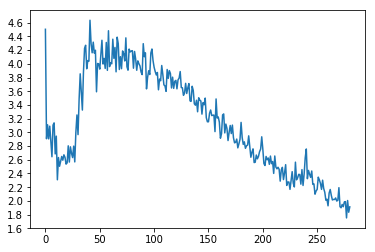

In [34]:
MAX_LENGTH = 80
batches = 28100 # In this case, the PyTorch train_per_epoch() and train() code is using batch_size=1
hidden_size = 100

my_encoder = EncoderRNN(len(english_vocab), hidden_size)
my_decoder = DecoderRNN(hidden_size, len(indo_vocab))

if use_cuda:
    my_encoder = my_encoder.cuda()
    my_decoder = my_decoder.cuda()

train(my_encoder, my_decoder, batches, print_every=100)

In [35]:
# Here's a nice bleeding edge Python trick, (only works on Python3.6)
# F-strings for the win!!
# See https://www.python.org/dev/peps/pep-0498/
print(hidden_size, batches)
print(f'encoder_vanilla_{hidden_size}_{batches}.pkl')

100 28100
encoder_vanilla_100_28100.pkl


In [36]:
import pickle 

# In Python >= 3.6
with open(f'./models/encoder_vanilla_{hidden_size}_{batches}.pkl', 'wb') as fout:
    pickle.dump(my_encoder, fout)
with open(f'./models/decoder_vanilla_{hidden_size}_{batches}.pkl', 'wb') as fout:
    pickle.dump(my_decoder, fout)

# For Python < 3.6
with open('./models/encoder_vanilla_{}_{}.pkl'.format(hidden_size, batches), 'wb') as fout:
    pickle.dump(my_encoder, fout)
with open('./models/decoder_vanilla_{}_{}.pkl'.format(hidden_size, batches), 'wb') as fout:
    pickle.dump(my_decoder, fout)

In [37]:
def translate(kopi_order):
    output_words = translator(my_encoder, my_decoder, variable_from_sent(kopi_order, english_vocab))
    print(output_words)
    output_sentence = [indo_vocab[i] for i in output_words[1:output_words.index(1)]]
    return ' '.join(output_sentence)

In [38]:
translate('French Muslims fined for face veils')

[0, 6, 7, 3, 383, 5, 2, 1]


'muslimah prancis didenda : mengenakan burka'